# Example 5.7

Assume $C = 1.9$, $D = 2$, $\alpha = 0.9$ and payments $\Delta$ have the discrete distribution

\begin{equation}
\Delta = \begin{cases}
\pm \tfrac{x}{2}, & \text{with probability } \tfrac{1}{4} - \tfrac{p}{2}, \\
\pm x, & \text{with probability } p, \\
\pm \tfrac{3x}{2}, & \text{with probability } \tfrac{1}{4} - \tfrac{p}{2},
\end{cases}
\end{equation}

where $x = 3.2$ and $p = 0.49$.

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

# Fix values 
C = 1.9
D = 2
alpha = 0.9
p = 0.49
x = 3.2

The optimal channel deposits will be of the form $l_A = n\tfrac{x}{2}$ and $l_B = m\tfrac{x}{2}$ where $n, m \in \mathbb{N}$ by the discrete nature of the payments.

Let $P$ be the vector of payment probabilites, that is

\begin{equation}
P[i] := \mathbb{P}[\Delta = \tfrac{-3x}{2} + i \tfrac{x}{2}], \quad i \in \{0, 1, \ldots, 7 \}.
\end{equation}

Let $h$ be the vector of "huge" jump probabilities. This depends on the size of the channel. Given $n$ and $m$, 

\begin{equation}
h[i] := \mathbb{P}[-n\tfrac{x}{2} + i\tfrac{x}{2} + \Delta \notin [-n\tfrac{x}{2}, m\tfrac{x}{2}]], \quad i \in \{0, 1, \ldots, n+m\}.
\end{equation}

In [161]:
# Create P vector
P = np.array([1/4 - p/2, p, 1/4 - p/2, 0, 1/4 - p/2, p, 1/4 - p/2])


# Create h vector depending on n and m
def create_h_vector(n, m):
    N = n + m 
    h = np.zeros(N + 1)  # Initialize h with zeros of length N

    # Populate h with the appropriate probabilities
    for i in range(N + 1):
        if i == 0:
            if N - i == 1:
                h[i] = P[0] + P[1] + P[2] + P[5] + P[6]
            elif N - i == 2:
                h[i] = P[0] + P[1] + P[2] + P[6]
            elif N - i >= 3:
                h[i] = P[0] + P[1] + P[2] 
        elif i == 1:
            if N - i == 0:
                h[i] = P[0] + P[1] + P[4] + P[5] + P[6]
            elif N - i == 1:
                h[i] = P[0] + P[1] + P[5] + P[6]
            elif N - i == 2:
                h[i] = P[0] + P[1] + P[6]
            elif N - i >= 3:
                h[i] = P[0] + P[1] 
        elif i == 2:
            if N - i == 0:
                h[i] = P[0] + P[4] + P[5] + P[6]
            elif N - i == 1:
                h[i] = P[0] + P[5] + P[6]
            elif N - i == 2:
                h[i] = P[0] + P[6]
            elif N - i >= 3:
                h[i] = P[0]
        elif i >= 3:
            if N - i == 0:
                h[i] = P[4] + P[5] + P[6]
            elif N - i == 1:
                h[i] = P[5] + P[6]
            elif N - i == 2:
                h[i] = P[6]
            elif N - i >= 3:
                h[i] = 0

    return h

# Examples
create_h_vector(0, 5), create_h_vector(3, 0), create_h_vector(2, 2)

(array([0.5  , 0.495, 0.005, 0.005, 0.495, 0.5  ]),
 array([0.5, 0.5, 0.5, 0.5]),
 array([0.5  , 0.495, 0.01 , 0.495, 0.5  ]))

Refining Algorithm 1 from our paper, in order to find the total cost given channel deposits $l_A = n\tfrac{x}{2}$ and $l_B = m\tfrac{x}{2}$, we need to find the fixed point of the function $F:\mathbb{R}^{n+m+1} \to \mathbb{R}^{n+m+1}$ defined by

\begin{equation}
F(v)[i] = \alpha \left[ \min(C+v[i], C+D+v[n]) \cdot h[i] + \sum_{j = \max(-i,-3)}^{\min(3, n+m-i)} \min(C+v[i], D+v[n], v[i+j]) \cdot P[3+j] \right], \quad i \in \{0, 1, \ldots, n+m \}.
\end{equation}

The code below does exactly this.

In [142]:
# Find the fixed point of the function F
def F(v, n, m):
    N = n + m
    h = create_h_vector(n, m)
    
    Fv = np.zeros(N+1)
    base_index = n

    # Compute the vector F(v)
    for i in range(N+1):
        # from position -nx/2 + ix/2, the next state could be -nx/2 + (i+j)x/2 for j between j_min and j_max
        j_min = max(-i, -3)
        j_max = min(3, N - i)
        
        Fv[i] = alpha * (
            min(C + v[i], C + D + v[base_index]) * h[i] +
            sum(min(C + v[i], D + v[base_index], v[i + j]) * P[3 + j] for j in range(j_min, j_max + 1))
        )
    
    return Fv

# The unique fixed point of F is the unique root of the function G(v)=F(v)-v
def G(v, n, m):
    Fv = F(v, n, m)
    Gv = Fv - v
    return Gv


# This finds the unique root of the function G, and hence the unique fixed point of F
def T(n, m, method='hybr'):
    
    # Set up the initial guess vector U-shaped
    N = n + m
    base_index = n
    initial_guess_vector = np.concatenate((base_index - np.arange(base_index), np.arange(N + 1 - base_index))) 
    
    # Use the root function from scipy.optimize with flexibility in the method 
    Fixed_Point = root(G, initial_guess_vector, args=(n, m), method=method)
        
    return Fixed_Point.x

# The total cost of the channel [-nx/2, mx/2]
def V(n,m):
    base_index = n
    return n*x/2 + m*x/2 + T(n,m)[base_index]

Since the resulting cost for not opening a channel is $\tfrac{\alpha C}{1-\alpha} = 17.1$, we only need to consider $n$ and $m$ such that $n\tfrac{x}{2} + m\tfrac{x}{2} \leq 17.1$. As $x = 3.2$, this is implied by $n + m \leq 11$. So we optimize over this set.

In [164]:
min_value = float('inf')
optimal_pair = (None, None)

# Find the optimal channel deposits
for n in range(1, 12):  # n is a natural number, so start at 1
        for m in range(1, 12):  # m is a natural number, so start at 1
            if n + m <= 11:  # Ensure n + m <= 11
                # Calculate the value of nx/2 + mx/2 + T(n, m)
                value = V(n,m)
                # Check if this is the minimal value found so far
                if value < min_value:
                    min_value = value
                    optimal_pair = (n, m)

optimal_pair

(2, 2)

Thus, the optimal channel deposits are $l_A^* = 2 \tfrac{x}{2}$ and $l_B^* = 2 \tfrac{x}{2}$.

Finally, we want to compute the optimal policy. We do this by using Theorem 3.2 and the plot below.

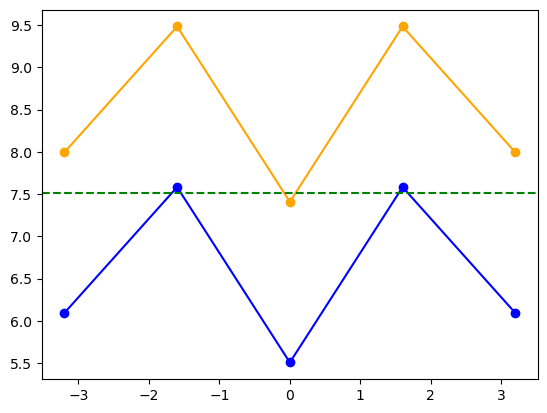

In [146]:
optimal_transaction_cost_vector = T(2, 2)

# Define x-axis values corresponding to elements of optimal_transaction_cost_vector
x_values = np.array([-3.2, -1.6, 0, 1.6, 3.2])

# Calculate C + optimal_transaction_cost_vector (element-wise addition)
C_plus_optimal_transaction_cost_vector = C + optimal_transaction_cost_vector

# Plot optimal_transaction_cost_vector, C+optimal_transaction_cost_vector, and D+optimal_transaction_cost_vector[2]
plt.plot(x_values, optimal_transaction_cost_vector, marker='o', color='blue')
plt.plot(x_values, C_plus_optimal_transaction_cost_vector, marker='o', color='orange')
plt.axhline(y=D + optimal_transaction_cost_vector[2], color='green', linestyle='--')
plt.show()

When the channel is opened the initial state is $0$:

- If a payment of $\pm \tfrac{x}{2}$ or $\pm \tfrac{3x}{2}$ is due, then the optimal action is $(Cn, W)$.
- If a payment of $\pm x$ is due, then the optimal action is $(Cl, W)$.

At position $x$:

- If a payment of $\tfrac{x}{2}$ or $x$ or $\tfrac{3x}{2}$ is due, then the optimal action is $(Cn, W)$.
- If a payment of $-x$ is due, then the optimal action is $(Cl,W)$.
- If a payment of $-\tfrac{3x}{2}$ or $-\tfrac{x}{2}$ is due, then the optimal action is $(Cl,R)$.

At position $-x$:

- If a payment of $-\tfrac{x}{2}$ or $-x$ or $-\tfrac{3x}{2}$ is due, then the optimal action is $(Cn, W)$.
- If a payment of $x$ is due, then the optimal action is $(Cl,W)$.
- If a payment of $\tfrac{3x}{2}$ or $\tfrac{x}{2}$ is due, then the optimal action is $(Cl,R)$.